In [2]:
import math
import pandas as pd
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from gc_aux import r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler

In [18]:
#define the model

class GPModel(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        super(GPModel, self).__init__(x_train, y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        
        self.rbf_kernel_1 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.rbf_kernel_2 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
        self.covar_module = gpytorch.kernels.AdditiveKernel(self.rbf_kernel_1, self.rbf_kernel_2)

    def forward(self, x):
        x_mean = self.mean_module(x)
        x_covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(x_mean, x_covar)

In [3]:
# load the data
df_raw = pd.read_excel('data/LFVL_v2.xlsx')
df_val_test_raw = pd.read_excel('data/val_test.xlsx')
#splitting the train set and val/test set
duplicates = df_raw['SMILES'].isin(df_val_test_raw['SMILES'])
df_train = df_raw[~duplicates]
df_val_test = df_raw[duplicates]

In [4]:
df_train_raw = df_train
df_val_test_raw = df_val_test

In [4]:
df_raw = pd.read_excel('data/Zc.xlsx')

In [5]:
df_train, df_val_test = train_test_split(df_raw, test_size=0.4, random_state=250)

prop_tag = 'Tc'

In [6]:
from sklearn.utils import shuffle

#re splitting the train and val/test set
total_rows = len(df_train) + len(df_val_test)
target_rows_80 = int(total_rows * 0.8)
target_rows_85 = int(total_rows * 0.85)
target_rows_90 = int(total_rows * 0.9)
target_rows_95 = int(total_rows * 0.95)

def split_datasets(df_train, df_val_test, target_rows):
    df_val_test_randomized = shuffle(df_val_test, random_state=0)
    
    rows_to_transfer = target_rows - len(df_train)
    
    df_train_new = pd.concat([df_train, df_val_test_randomized.iloc[:rows_to_transfer]])
    df_val_test_new = df_val_test_randomized.iloc[rows_to_transfer:]
    
    return df_train_new, df_val_test_new

df_train_80, df_val_test_80 = split_datasets(df_train, df_val_test, target_rows_80)
df_train_85, df_val_test_85 = split_datasets(df_train, df_val_test, target_rows_85)
df_train_90, df_val_test_90 = split_datasets(df_train, df_val_test, target_rows_90)
df_train_95, df_val_test_95 = split_datasets(df_train, df_val_test, target_rows_95)

In [7]:
smiles_list = ['O=CO', 'FCC(F)(F)F', 'Cc1ccccc1OP(=O)(Oc1ccccc1C)Oc1ccccc1C', 
               'O=C(O)C1=C[C@H](O)[C@@H](O)[C@@H](O[C@@H]2[C@H](O)[C@@H](O)C(O)O[C@@H]2C(=O)O)O1',
              'CCOS(=O)(=O)O']
len_move = len(smiles_list)

df_to_move = df_val_test_80[df_val_test_80['SMILES'].isin(smiles_list)]
row_to_move = df_train_80.iloc[[-len_move]]

df_train_80 = df_train_80.drop(row_to_move.index)
df_train_80 = pd.concat([df_train_80, df_to_move], ignore_index=True)

df_val_test_80 = df_val_test_80[~df_val_test_80['SMILES'].isin(smiles_list)]
df_val_test_80 = pd.concat([df_val_test_80, row_to_move], ignore_index=True)

df_train_80.to_csv('data/df_train_95.csv', index=False)

In [8]:
smiles_list = ['O=CO', 'FCC(F)(F)F', 'Cc1ccccc1OP(=O)(Oc1ccccc1C)Oc1ccccc1C', 
               'O=C(O)C1=C[C@H](O)[C@@H](O)[C@@H](O[C@@H]2[C@H](O)[C@@H](O)C(O)O[C@@H]2C(=O)O)O1',
              'CCOS(=O)(=O)O']
len_move = len(smiles_list)

df_to_move = df_val_test_90[df_val_test_90['SMILES'].isin(smiles_list)]
row_to_move = df_train_90.iloc[[-len_move]]

df_train_90 = df_train_90.drop(row_to_move.index)
df_train_90 = pd.concat([df_train_90, df_to_move], ignore_index=True)

df_val_test_90 = df_val_test_90[~df_val_test_90['SMILES'].isin(smiles_list)]
df_val_test_90 = pd.concat([df_val_test_90, row_to_move], ignore_index=True)

In [9]:
# extract G
# df_grp_raw = df_raw.loc[:,'Group 1':]
df_grp_raw = df_raw.loc[:,'CH3':]
df_grp_raw = df_grp_raw.iloc[:,:220+130+74]
# G = df_grp_raw.loc[:, (df_raw != 0).any(axis=0)].to_numpy()
G = df_grp_raw.to_numpy()

df_target_raw = df_raw['Const_Value']
y = df_target_raw.to_numpy()

In [10]:
#preparing train set
df_train = df_train_80

# extract target values
df_target = df_train['Const_Value']
# extract all groups
df_grp = df_train.loc[:,'CH3':]
df_grp = df_grp.iloc[:,:220+130+74]
# df_grp = df_raw[df_raw.columns[2:]]

# extract G
# G_train = df_grp.loc[:, (df_raw != 0).any(axis=0)].to_numpy()
G_train = df_grp.to_numpy()
y_train = df_target.to_numpy()

In [11]:
G_train.shape

(4766, 424)

In [12]:
#prepare val/test set

df_val_test = df_val_test_80

# extract target values
df_vt_target = df_val_test['Const_Value']
# extract all groups
df_vt_grp = df_val_test.loc[:,'CH3':]
df_vt_grp = df_vt_grp.iloc[:,:220+130+74]

# extract G
# G_vt = df_vt_grp.loc[:, (df_grp != 0).any(axis=0)].to_numpy()
G_vt = df_vt_grp.to_numpy()
y_vt_fog = df_vt_target.to_numpy()
#splitting the validation, test set

G_val, G_test, y_val, y_test = train_test_split(G_vt, y_vt_fog, test_size=0.5, random_state=42)

In [13]:
#double checking the groups appearance in val/test set
sum_G = G.sum(axis=0)
sum_G_vt = G_vt.sum(axis=0)

count = (sum_G_vt > sum_G).sum()

sum_G, sum_G_vt, count

(array([12460, 28378,  2845,   978,   304,   493,   137,   229,    21,
            6,     1,     1,    50,    65,  4034,   270,   106,   110,
           75,   726,   379,   150,    81,    21,    16,    10,     1,
            0,   986,   149,   216,     5,    83,    71,     4,     2,
            8,    85,    12,    67,   194,    26,     5,    35,    41,
            0,     1,    66,    49,   109,    11,     8,    16,   114,
           56,    15,    57,    97,     5,    79,    76,    38,    19,
           19,     7,     0,     0,    45,     9,     3,     0,    14,
            4,     0,     1,     7,    23,     9,     3,    18,     1,
            0,     9,     1,     1,     6,     1,     0,     1,     0,
            0,     0,     0,     0,     0,     0,     0,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,   186,
           76,    36,    61,    16,    25,    98,    43,    12,    79,
           81,    94,     6,    12,     8,    58,     8,     0,     3,
      

In [14]:
#define the scaler
scaler_LFVL = StandardScaler()
#fit the scaler
scaler_LFVL.fit(y.reshape(-1, 1))
#apply scaler
ys = scaler_LFVL.transform(y.reshape(-1, 1)).reshape(y.size,)
ys_train = scaler_LFVL.transform(y_train.reshape(-1, 1)).reshape(y_train.size,)
ys_val = scaler_LFVL.transform(y_val.reshape(-1, 1)).reshape(y_val.size,)
ys_test = scaler_LFVL.transform(y_test.reshape(-1, 1)).reshape(y_test.size,)

In [15]:
#preparing torch tensor
# G_train_to = torch.from_numpy(G_train).float()
G_train_to = torch.from_numpy(G_train).float()
y_train_to = torch.from_numpy(ys_train).float()
G_val_to = torch.from_numpy(G_val).float()
G_test_to = torch.from_numpy(G_test).float()
y_val_to = torch.from_numpy(ys_val).float()
y_test_to = torch.from_numpy(ys_test).float()
G_to = torch.from_numpy(G).float()

In [21]:
likelihood_gpr = gpytorch.likelihoods.GaussianLikelihood()
gpr = GPModel(G_train_to, y_train_to, likelihood_gpr)

optimizer_gpr = torch.optim.Adam(gpr.parameters(), lr=1e-3, weight_decay=0.1)
scheduler_gpr = ReduceLROnPlateau(optimizer_gpr, 'min', factor=0.1, patience=100, verbose=True)

mll_gpr = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_gpr, gpr)

In [22]:
for name, param in gpr.named_parameters():
    print(f'{name}: {param}')
    
for name, param in likelihood_gpr.named_parameters():
    print(f'{name}: {param.item()}')
    
for constraint_name, constraint in gpr.named_constraints():
    print(f'Constraint name: {constraint_name:55} constraint = {constraint}')

likelihood.noise_covar.raw_noise: Parameter containing:
tensor([0.], requires_grad=True)
mean_module.raw_constant: Parameter containing:
tensor(0., requires_grad=True)
rbf_kernel_1.raw_outputscale: Parameter containing:
tensor(0., requires_grad=True)
rbf_kernel_1.base_kernel.raw_lengthscale: Parameter containing:
tensor([[0.]], requires_grad=True)
rbf_kernel_2.raw_outputscale: Parameter containing:
tensor(0., requires_grad=True)
rbf_kernel_2.base_kernel.raw_lengthscale: Parameter containing:
tensor([[0.]], requires_grad=True)
noise_covar.raw_noise: 0.0
Constraint name: likelihood.noise_covar.raw_noise_constraint             constraint = GreaterThan(1.000E-04)
Constraint name: rbf_kernel_1.raw_outputscale_constraint                 constraint = Positive()
Constraint name: rbf_kernel_1.base_kernel.raw_lengthscale_constraint     constraint = Positive()
Constraint name: rbf_kernel_2.raw_outputscale_constraint                 constraint = Positive()
Constraint name: rbf_kernel_2.base_kernel

In [23]:
training_iter = 50000
train_losses = []
val_losses = []

best_loss = float('inf')
cnt = 0
patience = 500

for i in range(training_iter):
    gpr.train()
    likelihood_gpr.train()

    optimizer_gpr.zero_grad()
    output = gpr(G_train_to)
    loss = -mll_gpr(output, y_train_to)
    loss.backward()
    optimizer_gpr.step()
    train_losses.append(loss.item())

    gpr.eval()
    likelihood_gpr.eval()
    with torch.no_grad():
        val_output = gpr(G_val_to)
        val_loss = -mll_gpr(val_output, y_val_to)
        val_loss_mae =  mean_absolute_error(y_val_to.numpy(), val_output.mean.numpy())
        #early stopping
        if val_loss_mae < best_loss:
            best_loss = val_loss_mae
            cnt = 0
            torch.save(gpr.state_dict(), 'gpr_all_'+ prop_tag +'.pth')
        else:
            cnt += 1
            if cnt >= patience:
                print(f'[{i:>{len(str(training_iter))}}/{training_iter:>{len(str(training_iter))}}]'+"Early stopping")
                break
                
    val_losses.append(val_loss)
    scheduler_gpr.step(val_loss)
    
    msg = (f'[{i:>{len(str(training_iter))}}/{training_iter:>{len(str(training_iter))}}]' +
       f'train loss:{loss.item():.5f}' + 
       f'validation loss:{val_loss.item():.5f}')   
    if i%100 == 0:
        print(msg)

D:\Users\49332\anaconda3\envs\test\lib\site-packages\gpytorch\functions\_pivoted_cholesky.py:118: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:2198.)
  [L, torch.triangular_solve(Krows[..., m:, :].transpose(-1, -2), L, upper=False)[0].transpose(-1, -2)],


[    0/50000]train loss:1.32420validation loss:1.20228
[  100/50000]train loss:1.27698validation loss:1.15257
[  200/50000]train loss:1.23640validation loss:1.10328
[  300/50000]train loss:1.19369validation loss:1.05495
[  400/50000]train loss:1.14851validation loss:1.00810
[  500/50000]train loss:1.11099validation loss:0.96345
[  600/50000]train loss:1.07334validation loss:0.92071
[  700/50000]train loss:1.04147validation loss:0.88060
[  800/50000]train loss:1.00958validation loss:0.84266
[  900/50000]train loss:0.98117validation loss:0.80741
[ 1000/50000]train loss:0.95226validation loss:0.77420
[ 1100/50000]train loss:0.92143validation loss:0.74357
[ 1200/50000]train loss:0.89982validation loss:0.71505
[ 1300/50000]train loss:0.87884validation loss:0.68884
[ 1400/50000]train loss:0.85883validation loss:0.66430
[ 1500/50000]train loss:0.84346validation loss:0.64189
[ 1600/50000]train loss:0.82422validation loss:0.62154
[ 1700/50000]train loss:0.80897validation loss:0.60240
[ 1800/500

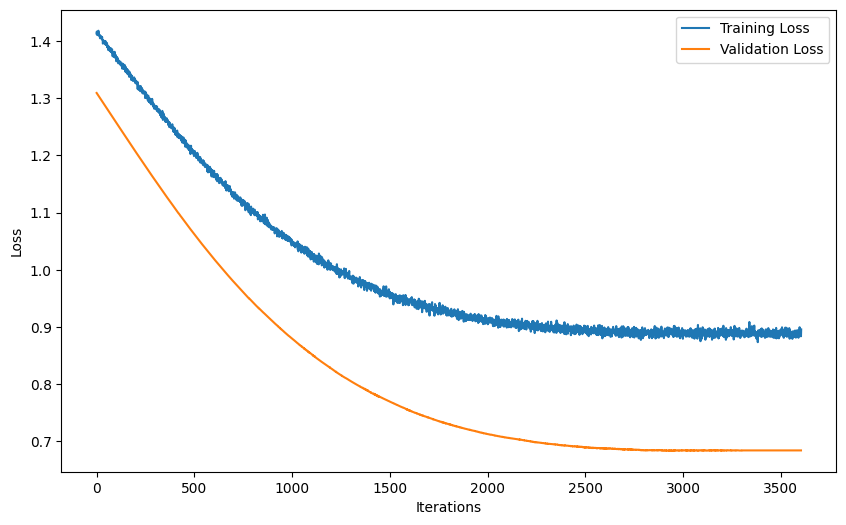

In [281]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.savefig('gpr_figure_Folder/'+prop_tag+'_all_groups_loss.pdf')
plt.show()

In [282]:
for name, param in gpr.named_parameters():
    print(f'{name}: {param}')
    
for name, param in likelihood_gpr.named_parameters():
    print(f'{name}: {param.item()}')
    
for constraint_name, constraint in gpr.named_constraints():
    print(f'Constraint name: {constraint_name:55} constraint = {constraint}')
    
for param_group in optimizer_gpr.param_groups:
    print("Current learning rate is: {}".format(param_group['lr']))

likelihood.noise_covar.raw_noise: Parameter containing:
tensor([-1.4845], requires_grad=True)
mean_module.raw_constant: Parameter containing:
tensor(0.4898, requires_grad=True)
rbf_kernel_1.raw_outputscale: Parameter containing:
tensor(-0.5493, requires_grad=True)
rbf_kernel_1.base_kernel.raw_lengthscale: Parameter containing:
tensor([[1.1064]], requires_grad=True)
rbf_kernel_2.raw_outputscale: Parameter containing:
tensor(-0.5493, requires_grad=True)
rbf_kernel_2.base_kernel.raw_lengthscale: Parameter containing:
tensor([[1.1064]], requires_grad=True)
noise_covar.raw_noise: -1.4845460653305054
Constraint name: likelihood.noise_covar.raw_noise_constraint             constraint = GreaterThan(1.000E-04)
Constraint name: rbf_kernel_1.raw_outputscale_constraint                 constraint = Positive()
Constraint name: rbf_kernel_1.base_kernel.raw_lengthscale_constraint     constraint = Positive()
Constraint name: rbf_kernel_2.raw_outputscale_constraint                 constraint = Positive(

In [24]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    ys_pred_test = likelihood_gpr(gpr(G_test_to))
    ys_pred_train = likelihood_gpr(gpr(G_train_to))
    ys_pred_val = likelihood_gpr(gpr(G_val_to))
    ys_pred = likelihood_gpr(gpr(G_to))

D:\Users\49332\anaconda3\envs\test\lib\site-packages\gpytorch\models\exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [25]:
y_pred_test = scaler_LFVL.inverse_transform(ys_pred_test.mean.detach().numpy().reshape(-1, 1)).reshape(y_test.size,)
y_pred_train = scaler_LFVL.inverse_transform(ys_pred_train.mean.detach().numpy().reshape(-1, 1)).reshape(y_train.size,)
y_pred_val = scaler_LFVL.inverse_transform(ys_pred_val.mean.detach().numpy().reshape(-1, 1)).reshape(y_val.size,)

y_pred_test_vars = scaler_LFVL.inverse_transform(ys_pred_test.variance.detach().numpy().reshape(-1, 1)).reshape(y_test.size,)

mae_all = mean_absolute_error(y_test, y_pred_test)
r2_all = r2_score(y_test, y_pred_test)

print("MAE on test set:", mae_all)
print("R2 on test set:", r2_all)

MAE on test set: 0.0069140683606242
R2 on test set: 0.8884944686939364


In [26]:
print('MAE on train set',mean_absolute_error(y_train, y_pred_train))
print('R2 on train set',r2_score(y_train, y_pred_train))

MAE on train set 0.0033119454368467443
R2 on train set 0.978816621473163


In [27]:
print('MAE on val set',mean_absolute_error(y_val, y_pred_val))
print('R2 on val set',r2_score(y_val, y_pred_val))

MAE on val set 0.007625364786126468
R2 on val set 0.8940369974278845


In [28]:
y_pred = scaler_LFVL.inverse_transform(ys_pred.mean.detach().numpy().reshape(-1, 1)).reshape(y.size,)

mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)
print("MAE on test set:", mae)
print("R2 on test set:", r2)

MAE on test set: 0.004104395424695518
R2 on test set: 0.963034784362208


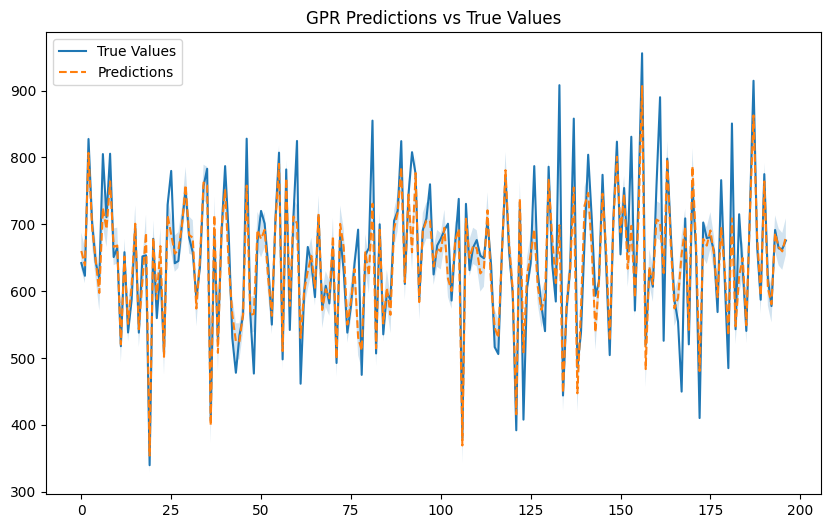

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(y_pred_test, label='Predictions', linestyle='--')
plt.fill_between(np.arange(len(y_test)), 
                 y_pred_test - np.sqrt(y_pred_test_vars), 
                 y_pred_test + np.sqrt(y_pred_test_vars), 
                 alpha=0.2)
plt.legend()
plt.title("GPR Predictions vs True Values")
plt.show()

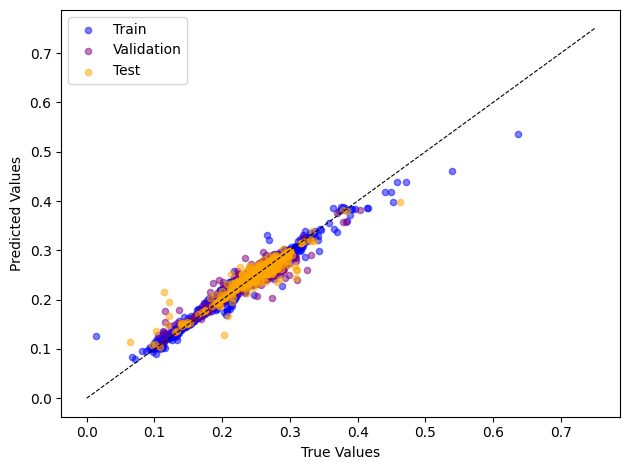

In [196]:
plt.scatter(y_train, y_pred_train, color='blue',s=20, alpha=0.5, label='Train')
plt.scatter(y_val, y_pred_val, color='purple', s=20, alpha=0.5, label='Validation')
plt.scatter(y_test, y_pred_test, color='orange',s=20, alpha=0.5, label='Test')

plt.plot([0, 0.75], [0, 0.75], color='black', linestyle='--',linewidth=0.8)

# plt.xlim(0, 100)
# plt.ylim(0, 100)

plt.legend(loc='upper left') 

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.tight_layout()
plt.savefig('gpr_figure_Folder/'+prop_tag+'_all_groups_gpr_1.pdf')

plt.show()

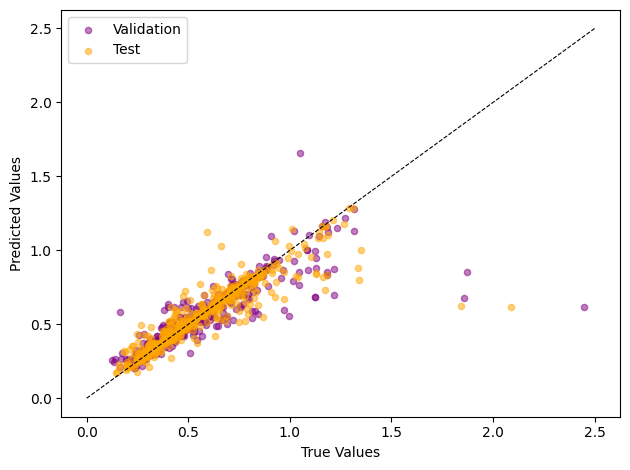

In [117]:
plt.scatter(y_val, y_pred_val, color='purple', s=20, alpha=0.5, label='Validation')
plt.scatter(y_test, y_pred_test, color='orange',s=20, alpha=0.5, label='Test')

plt.plot([0, 2.5], [0, 2.5], color='black', linestyle='--',linewidth=0.8)

# plt.xlim(0, 100)
# plt.ylim(0, 100)

plt.legend(loc='upper left') 

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.tight_layout()
plt.savefig('gpr_figure_Folder/'+prop_tag+'_all_groups_gpr_4.pdf')

plt.show()

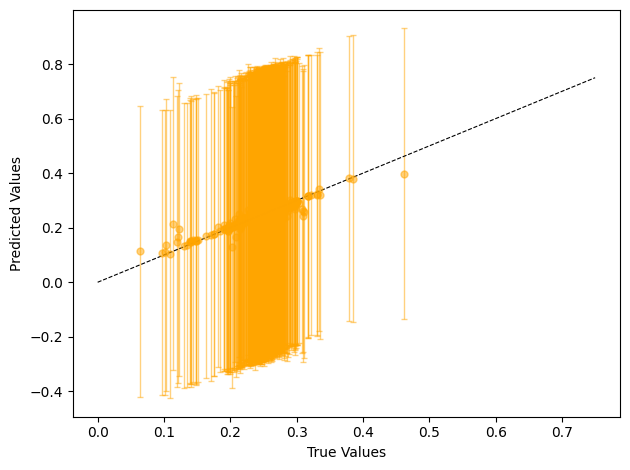

In [200]:
errors = np.sqrt(y_pred_test_vars)  

plt.errorbar(y_test, y_pred_test, yerr=errors,markersize=5, fmt='o', color='orange', ecolor='orange', elinewidth=1, capsize=2, alpha=0.5, label='Test')

plt.plot([0, 0.75], [0, 0.75], color='black', linestyle='--',linewidth=0.8)

# plt.xlim(0, 100)
# plt.ylim(0, 100)

# plt.legend()

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.tight_layout()

plt.savefig('gpr_figure_Folder/'+prop_tag+'_all_groups_gpr_5.pdf')

plt.show()

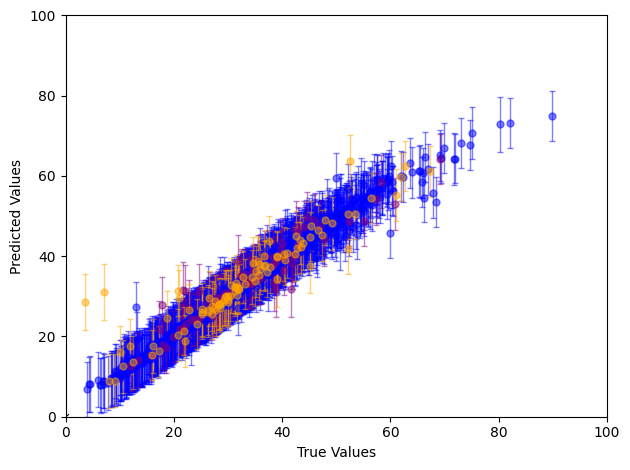

In [231]:
y_pred_train_vars = scaler_LFVL.inverse_transform(ys_pred_train.variance.detach().numpy().reshape(-1, 1)).reshape(y_train.size,)
y_pred_val_vars = scaler_LFVL.inverse_transform(ys_pred_val.variance.detach().numpy().reshape(-1, 1)).reshape(y_val.size,)

errors_te = np.sqrt(y_pred_test_vars)  
errors_tr = np.sqrt(y_pred_train_vars)  
errors_va = np.sqrt(y_pred_val_vars)  

plt.errorbar(y_train, y_pred_train, yerr=errors_tr, fmt='o', color='blue', markersize=5,ecolor='blue', elinewidth=1, capsize=2, alpha=0.5, label='Test')
plt.errorbar(y_val, y_pred_val, yerr=errors_va, fmt='o', color='purple', markersize=5,ecolor='purple', elinewidth=1, capsize=2, alpha=0.5, label='Test')
plt.errorbar(y_test, y_pred_test, yerr=errors_te, fmt='o', color='orange', markersize=5,ecolor='orange', elinewidth=1, capsize=2, alpha=0.5, label='Test')

plt.plot([0, 0.75], [0, 0.75], color='black', linestyle='--',linewidth=0.8)

plt.xlim(0, 100)
plt.ylim(0, 100)

# plt.legend()

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.tight_layout()

# plt.savefig('gpr_figure_Folder/'+prop_tag+'_all_groups_gpr_7.pdf')

plt.show()

In [201]:
print('ARE on train set',np.average(np.abs((y_train - y_pred_train) / y_train))*100)
print('ARE on val set',np.average(np.abs((y_val - y_pred_val) / y_val))*100)
print('ARE on test set',np.average(np.abs((y_test - y_pred_test) / y_test))*100)

print('ARE ',np.average(np.abs((y - y_pred) / y))*100)

ARE on train set 1.5798871912471475
ARE on val set 3.24839939584511
ARE on test set 3.1150917674507506
ARE  1.9006698295829978


In [66]:
result = []
for value in y_test:
    if value < 10:
        result.append(value)

print(result)

[7.118, 4.548, 3.612725, 9.13570375]


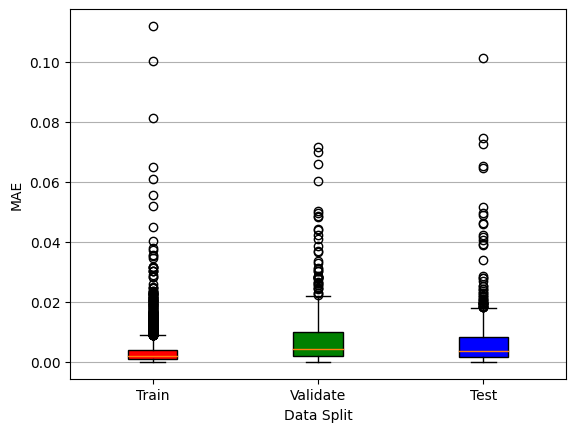

In [29]:
abs_errors_train = np.abs(y_train - y_pred_train)
abs_errors_val = np.abs(y_val - y_pred_val)
abs_errors_test = np.abs(y_test - y_pred_test)

data_MAE = [abs_errors_train, abs_errors_val, abs_errors_test]

colors = ['red', 'green', 'blue']

fig1, ax1 = plt.subplots()
bplot1 = ax1.boxplot(data_MAE, patch_artist=True)

ax1.yaxis.grid(True)

# ax1.set_ylim(0, 1)

plt.xticks([1, 2, 3], ['Train', 'Validate', 'Test'])

plt.ylabel('MAE')
plt.xlabel('Data Split')

for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)

plt.show()

In [30]:
df_raw = pd.read_excel('data/n-alkanes.xlsx')

In [31]:
df_grp = df_raw.loc[:,1:]
G = df_grp.to_numpy()

G_to = torch.from_numpy(G).float()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    ystest = likelihood_gpr(gpr(G_to))
    
ytest = scaler_LFVL.inverse_transform(ystest.mean.detach().numpy().reshape(-1, 1)).reshape(711,)

In [32]:
np.savetxt('my_array.txt', ytest)

ends here